In [2]:
%matplotlib inline

In [27]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from datetime import datetime, date
from sklearn_pandas import DataFrameMapper
import warnings
import timeit
from collections import defaultdict, OrderedDict
import tabulate
import time
import glob
from skimage import io, transform

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Resize to fixed size

In [5]:
NEW_SIZE = (512, 512, 3)
all_shirts = io.imread_collection('./data/LBA/*')

resized_images = []

for image in all_shirts:
    resized_images.append(transform.resize(image, NEW_SIZE))
    
resized_array = np.array(resized_images)
del(resized_images)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## Center the images

In [6]:
image_mean = np.mean(resized_array, axis=0)
centered_array = resized_array - image_mean
np.mean(centered_array)

1.7376146817701019e-17

## Reshape for PCA

In [7]:
reshaped_array = centered_array.reshape(centered_array.shape[0], -1) # np.product(centered_array.shape[1:])
reshaped_array.shape

(20, 786432)

## PCA

In [9]:
from sklearn.decomposition import PCA

pca = PCA(whiten=True, copy=True)
pca.fit(reshaped_array)
diffs = np.ediff1d(pca.explained_variance_ratio_)

## Plot PCA component explained variances

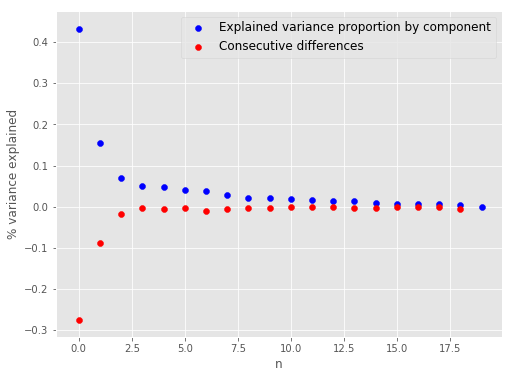

In [16]:
plt.figure(figsize=(8, 6))

plt.scatter(list(range(pca.explained_variance_ratio_.shape[0])), pca.explained_variance_ratio_, 
    color='blue', label='Explained variance proportion by component')

plt.scatter(list(range(diffs.shape[0])), diffs, 
    color='red', label='Consecutive differences')

plt.legend(loc=1, fontsize=12)
plt.xlabel(r'n', size=12)
plt.ylabel(r'% variance explained', size=12)
plt.show()

## Project to two dimensions as requested

And generate a scatter plot of the projections

In [31]:
DIMENSIONS = 2

pca_top_2 = PCA(n_components=DIMENSIONS, whiten=True, copy=True)
projections = pca_top_2.fit_transform(reshaped_array)

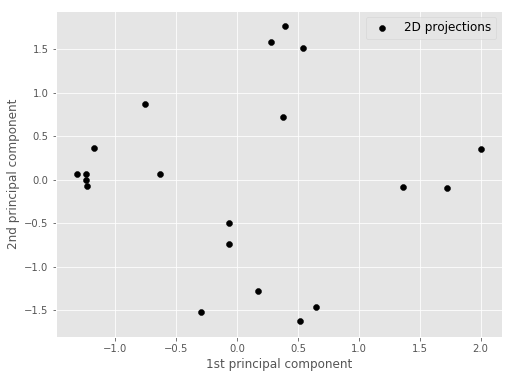

In [32]:
plt.figure(figsize=(8, 6))

plt.scatter(projections[:,0], projections[:,1], color='black', label='2D projections')

plt.legend(loc=1, fontsize=12)
plt.xlabel(r'1st principal component', size=12)
plt.ylabel(r'2nd principal component', size=12)
plt.show()

## Plot the original images:

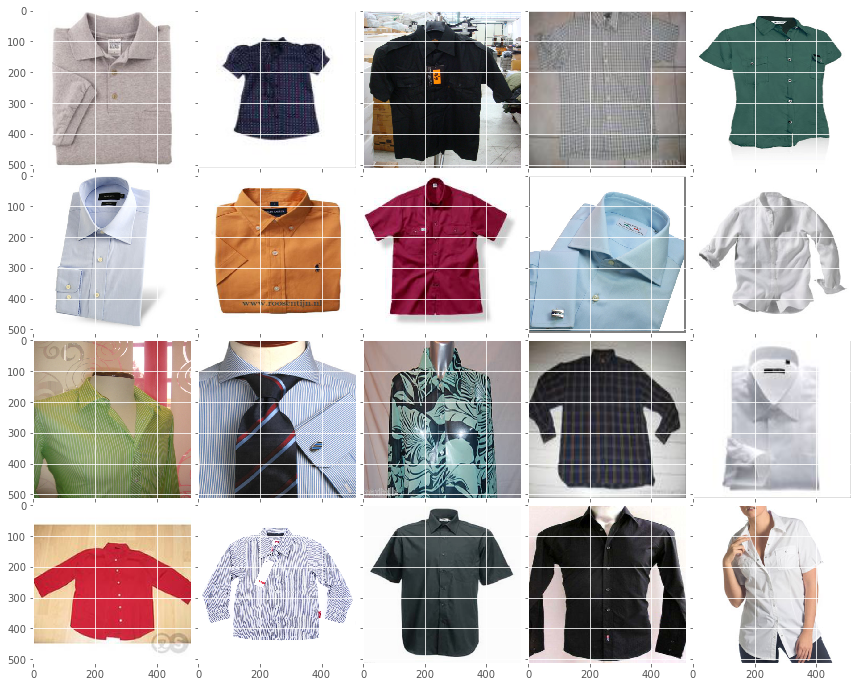

In [43]:
fig = plt.figure(1, (15, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(resized_array.shape[0]):
    grid[i].imshow(resized_array[i])  # The AxesGrid object work as a list of axes.


plt.show()

## And now the reconstructions:

In [33]:
reconstructions = projections.dot(pca_top_2.components_)
reshaped_reconstructions = reconstructions.reshape(resized_array.shape)

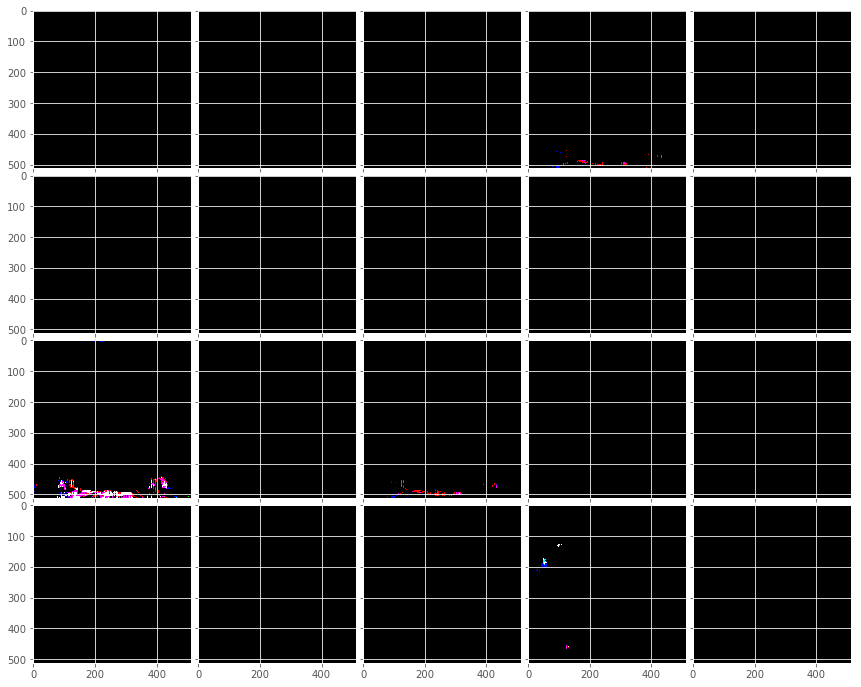

In [34]:
fig = plt.figure(1, (15, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(reshaped_reconstructions.shape[0]):
    grid[i].imshow(reshaped_reconstructions[i])  # The AxesGrid object work as a list of axes.


plt.show()

## Reconstruct some distant point and examine them

In [39]:
DISTANT_POINTS = ((2, 2), (2, -1.5), (-1, -1.5), (-1, 2))
distant_array = np.asarray(DISTANT_POINTS)
distant_reconst = distant_array.dot(pca_top_2.components_)
reshaped_distant_reconst = distant_reconst.reshape((len(DISTANT_POINTS), *resized_array.shape[1:]))

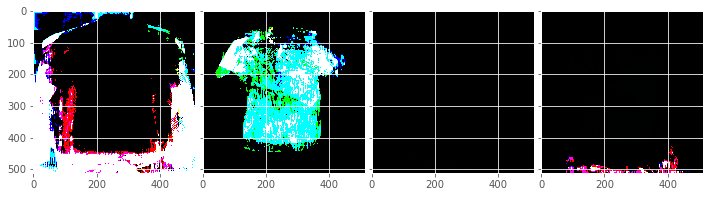

In [42]:
fig = plt.figure(1, (12, 4))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(reshaped_distant_reconst.shape[0]):
    grid[i].imshow(reshaped_distant_reconst[i])  # The AxesGrid object work as a list of axes.


plt.show()

## Anything else?
* Try in 3D?
* Try to add noise to reconstruction?
* Try to add mean to reconstruction?